In [1]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV

import seaborn as sns
sns.set_theme()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


from sklearn.preprocessing import MinMaxScaler
import shap



IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
df = pd.read_csv('df_dummy.csv', index_col=0)

In [3]:
df.head(5)

,NP_concentration,avg_NP_size,ZOI_drug,ZOI_drug_NP,fold_increase_in_antibacterial_activity (%),MDR_check,min_max_NP_size,lg_Drug_dose,avg_Incub_period,"growth_temp, C",...,Drug_polymyxin,Drug_rifampicin,Drug_streptomycin,Drug_tetracycline,Drug_trimethoprim,Drug_vancomycin,shape_spherical,method_disc_diffusion,method_well_diffusion,gram_p
0,30.0,8.0,32.0,32.0,0.468,1.0,6.0,2.114806,84.0,37.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,30.0,8.0,32.0,32.0,1.570,1.0,6.0,2.359176,84.0,37.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,30.0,28.0,32.0,32.0,0.468,1.0,15.0,2.114806,84.0,37.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,30.0,28.0,32.0,32.0,1.570,1.0,15.0,2.359176,84.0,37.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,100.0,21.0,0.0,17.0,7.020,1.0,25.0,1.477121,288.0,30.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0


In [4]:
df.drop(columns = ['Chi0', 'NumHDonors', 'LabuteASA'], inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 547 entries, 0 to 546
Data columns (total 95 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   NP_concentration                             547 non-null    float64
 1   avg_NP_size                                  547 non-null    float64
 2   ZOI_drug                                     547 non-null    float64
 3   ZOI_drug_NP                                  547 non-null    float64
 4   fold_increase_in_antibacterial_activity (%)  547 non-null    float64
 5   MDR_check                                    547 non-null    float64
 6   min_max_NP_size                              547 non-null    float64
 7   lg_Drug_dose                                 547 non-null    float64
 8   avg_Incub_period                             547 non-null    float64
 9   growth_temp, C                               547 non-null    float64
 10  biosafe

In [6]:
scaler = MinMaxScaler()

x = df.values
cols = df.columns
x_scaled = scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns=cols)
df


,NP_concentration,avg_NP_size,ZOI_drug,ZOI_drug_NP,fold_increase_in_antibacterial_activity (%),MDR_check,min_max_NP_size,lg_Drug_dose,avg_Incub_period,"growth_temp, C",...,Drug_polymyxin,Drug_rifampicin,Drug_streptomycin,Drug_tetracycline,Drug_trimethoprim,Drug_vancomycin,shape_spherical,method_disc_diffusion,method_well_diffusion,gram_p
0,0.222222,0.059675,0.500000,0.51200,0.039661,1.0,0.080000,0.756389,0.291667,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.222222,0.059675,0.500000,0.51200,0.133051,1.0,0.080000,0.858298,0.291667,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.222222,0.421338,0.500000,0.51200,0.039661,1.0,0.200000,0.756389,0.291667,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.222222,0.421338,0.500000,0.51200,0.133051,1.0,0.200000,0.858298,0.291667,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.000000,0.294756,0.000000,0.27200,0.594915,1.0,0.333333,0.490459,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,0.222222,0.059675,0.015625,0.00200,0.138983,0.0,0.080000,1.000000,0.125000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
543,0.222222,1.000000,0.004883,0.00160,0.016949,0.0,1.000000,0.391917,0.166667,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
544,0.222222,0.059675,0.000469,0.00048,0.091525,0.0,0.080000,1.000000,0.062500,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
545,0.222222,0.421338,0.000469,0.00048,0.091525,0.0,0.200000,1.000000,0.062500,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [7]:
def func_delimetr_train_test_2(df_train, df_target):
    X = df_train.astype('float32')
    y = df_target.astype('float32')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [8]:
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = func_delimetr_train_test_2(df.drop(columns = ["ZOI_drug_NP"],axis=1).astype('float32'), df['ZOI_drug_NP'].astype('float32'))

model = RandomForestRegressor()
model.fit(X_train,y_train)



RandomForestRegressor()

In [9]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

0.7751915436836767

In [10]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 2, 3]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
0.793968090374275


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


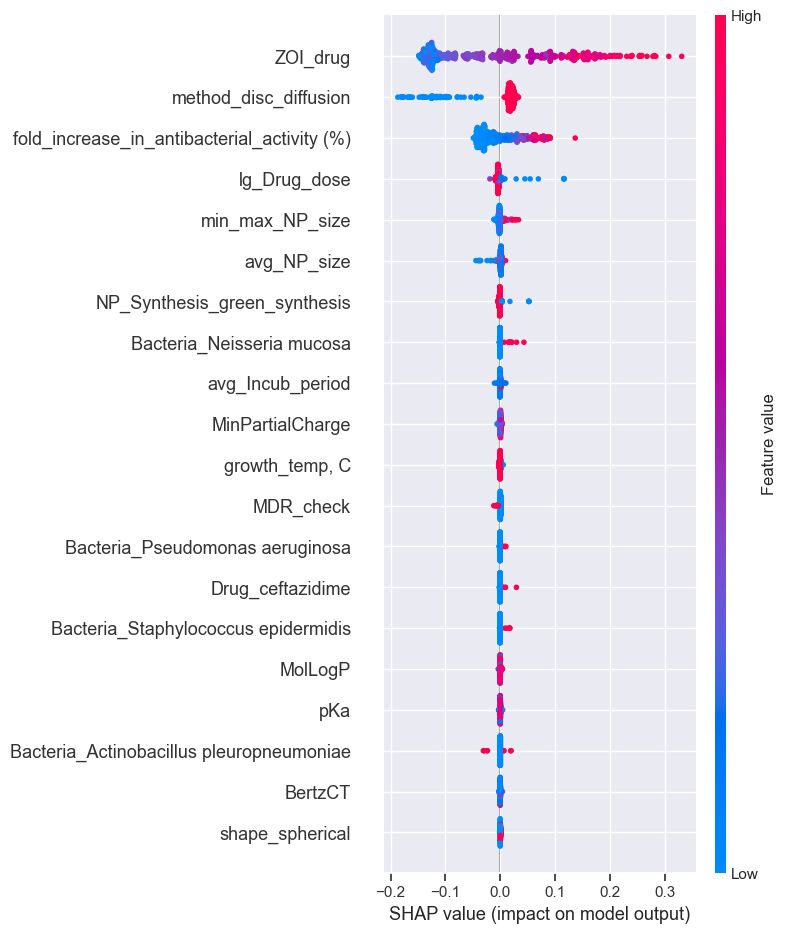

In [13]:
best_model = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_leaf=1)
best_model.fit(X_train, y_train)
expl = shap.Explainer(best_model, X_train)
shap_values = expl(X_train)
shap.summary_plot(shap_values, X_train)

In [14]:
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

0.7776822281280145